In [3]:
import cv2
import numpy as np
import os
import re
from tqdm import tqdm

raw_training_data = []
raw_test_data = []
label = {"cats": 0, "dogs": 1}

def read_data(path):
    tmp_data = []
    for file in tqdm(os.listdir(path)):
        if re.match("^(cat|dog).[0-9]+.jpg", file):
            full_path = os.path.join(path, file)
            img = cv2.imread(full_path)
            tmp_data.append([img, label[item_label]])
            
    return tmp_data

for item_label in label:
    raw_training_data += (read_data("dataset/training_set/" + item_label))
    raw_test_data += (read_data("dataset/test_set/" + item_label))
                

100%|██████████| 1013/1013 [00:02<00:00, 399.60it/s]


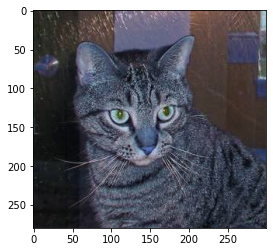

In [ ]:
# Check image
import matplotlib.pyplot as plt
plt.imshow(raw_training_data[0][0])

In [ ]:
# Check label
print(list(label.keys())[list(label.values()).index(raw_training_data[0][1])])

cats


In [ ]:
print(len(raw_training_data))
print(len(raw_test_data))

8000
2000


## CNN

In [4]:
import torchvision
import torchvision.transforms as transforms
import copy

training_data = copy.deepcopy(raw_training_data)
test_data = copy.deepcopy(raw_test_data)
image_size = (64,64)

def transform (img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, image_size)
    img = torchvision.transforms.functional.to_tensor(img)
    return img

for i in tqdm(range(len(raw_training_data))):
    training_data[i][0] = transform(raw_training_data[i][0])
    
for i in tqdm(range(len(raw_test_data))):
    test_data[i][0] = transform(raw_test_data[i][0])

100%|██████████| 2000/2000 [00:00<00:00, 3743.42it/s]


In [5]:
import torch 
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #CUDA is a GPU

num_classes = 2
num_epochs = 20
batch_size = 100
learning_rate = 0.001

train_loader = torch.utils.data.DataLoader(dataset=training_data, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_data, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [6]:
# Create the CNN model
class ConvNet(nn.Module):
    def __init__(self, num_classes = 2):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=5, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(6272, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [7]:
import time
model = ConvNet(num_classes).to(device)

# Set the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = 0.9)

# Set the time
start_time = time.time()

# Train the model
for epoch in range(num_epochs):
    num_corrects = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Count the number of correct classifications
        _, pred = torch.max(outputs,1)
        num_corrects += (pred == labels).float().sum()
    
    time_elapsed = int(time.time() - start_time)
    print ('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}, Time Elapsed: {:d} min {:d} sec.' 
           .format(epoch+1, num_epochs, loss.item(), num_corrects/len(training_data), time_elapsed // 60, time_elapsed % 60))

Epoch [1/20], Loss: 0.5514, Accuracy: 0.6624, Time Elapsed: 0 min 2 sec.
Epoch [2/20], Loss: 0.5134, Accuracy: 0.7706, Time Elapsed: 0 min 3 sec.
Epoch [3/20], Loss: 0.5126, Accuracy: 0.7690, Time Elapsed: 0 min 5 sec.
Epoch [4/20], Loss: 0.3155, Accuracy: 0.8351, Time Elapsed: 0 min 7 sec.
Epoch [5/20], Loss: 0.3849, Accuracy: 0.8584, Time Elapsed: 0 min 9 sec.
Epoch [6/20], Loss: 0.3269, Accuracy: 0.8703, Time Elapsed: 0 min 11 sec.
Epoch [7/20], Loss: 0.2339, Accuracy: 0.8959, Time Elapsed: 0 min 12 sec.
Epoch [8/20], Loss: 0.2194, Accuracy: 0.9034, Time Elapsed: 0 min 14 sec.
Epoch [9/20], Loss: 0.1893, Accuracy: 0.9345, Time Elapsed: 0 min 16 sec.
Epoch [10/20], Loss: 0.2263, Accuracy: 0.9521, Time Elapsed: 0 min 18 sec.
Epoch [11/20], Loss: 0.1700, Accuracy: 0.9666, Time Elapsed: 0 min 20 sec.
Epoch [12/20], Loss: 0.1156, Accuracy: 0.9794, Time Elapsed: 0 min 21 sec.
Epoch [13/20], Loss: 0.0678, Accuracy: 0.9920, Time Elapsed: 0 min 23 sec.
Epoch [14/20], Loss: 0.0913, Accuracy: 

In [ ]:
pred = np.array([])
actual = np.array([])

# Test the model
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        pred = np.append(pred, predicted.cpu())
        actual = np.append(actual, labels.cpu())

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

def summary(_pred, _actual):
    # Classification report
    print(classification_report(_actual, _pred, target_names = ["cats", "dogs"]))
    
    ax= plt.subplot()
    sns.heatmap(confusion_matrix(_actual, _pred) , annot=True, fmt='g', ax=ax)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['cats', 'dogs'])
    ax.yaxis.set_ticklabels(['cats', 'dogs'])

              precision    recall  f1-score   support

        cats       0.75      0.89      0.81      1000
        dogs       0.86      0.71      0.78      1000

    accuracy                           0.80      2000
   macro avg       0.81      0.80      0.79      2000
weighted avg       0.81      0.80      0.79      2000



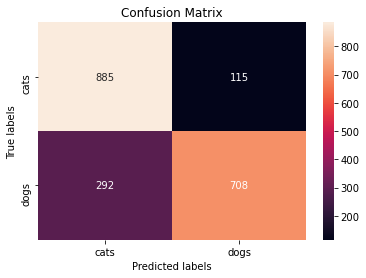

In [ ]:
summary(pred, actual)

In [ ]:
import torchvision
import torchvision.transforms as transforms
import copy

training_data = copy.deepcopy(raw_training_data)
test_data = copy.deepcopy(raw_test_data)
image_size = (224,224)

def transform (img):
    img = cv2.resize(img, image_size)
    img = torchvision.transforms.functional.to_tensor(img)
    return img

for i in tqdm(range(len(raw_training_data))):
    training_data[i][0] = transform(raw_training_data[i][0])
    
for i in tqdm(range(len(raw_test_data))):
    test_data[i][0] = transform(raw_test_data[i][0])

In [ ]:
import torch 
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #CUDA is a GPU

num_classes = 2
num_epochs = 10
batch_size = 20
learning_rate = 0.005

train_loader = torch.utils.data.DataLoader(dataset=training_data, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_data, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [ ]:
from torchvision import models
model = models.vgg16(pretrained=True)
model.classifier = nn.Sequential(
    nn.Linear(in_features=25088, out_features=4096),
    nn.ReLU(inplace=True),
    nn.Dropout(),
    nn.Linear(in_features=4096, out_features=4096),
    nn.ReLU(inplace=True),
    nn.Dropout(),
    nn.Linear(in_features=4096, out_features=2),
    nn.LogSoftmax(dim = 1)
  )

for param in model.features.parameters():
    param.requires_grad = False
    
model.to(device)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
import time
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.classifier.parameters(), lr=learning_rate, momentum = 0.9)

start_time = time.time()

for epoch in range(num_epochs):
    num_correct = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, pred = torch.max(outputs, 1)
        num_correct += (pred == labels).float().sum()
        
    time_elapsed = int(time.time() - start_time)
    print ('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}, Time Elapsed: {:d} min {:d} sec.' 
           .format(epoch+1, num_epochs, loss.item(), num_correct/len(training_data), time_elapsed // 60, time_elapsed % 60))


Epoch [1/10], Loss: 0.0110, Accuracy: 0.9280, Time Elapsed: 0 min 58 sec.
Epoch [2/10], Loss: 0.0392, Accuracy: 0.9718, Time Elapsed: 1 min 39 sec.
Epoch [3/10], Loss: 0.0214, Accuracy: 0.9866, Time Elapsed: 2 min 21 sec.
Epoch [4/10], Loss: 0.0861, Accuracy: 0.9930, Time Elapsed: 3 min 2 sec.
Epoch [5/10], Loss: 0.0001, Accuracy: 0.9968, Time Elapsed: 3 min 42 sec.
Epoch [6/10], Loss: 0.0015, Accuracy: 0.9986, Time Elapsed: 4 min 23 sec.
Epoch [7/10], Loss: 0.0119, Accuracy: 0.9991, Time Elapsed: 5 min 4 sec.
Epoch [8/10], Loss: 0.0012, Accuracy: 1.0000, Time Elapsed: 5 min 45 sec.
Epoch [9/10], Loss: 0.0002, Accuracy: 0.9999, Time Elapsed: 6 min 25 sec.
Epoch [10/10], Loss: 0.0046, Accuracy: 1.0000, Time Elapsed: 7 min 6 sec.


In [ ]:
pred = np.array([])
actual = np.array([])

# Test the model
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        pred = np.append(pred, predicted.cpu())
        actual = np.append(actual, labels.cpu())

              precision    recall  f1-score   support

        cats       0.95      0.98      0.97      1000
        dogs       0.98      0.95      0.97      1000

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



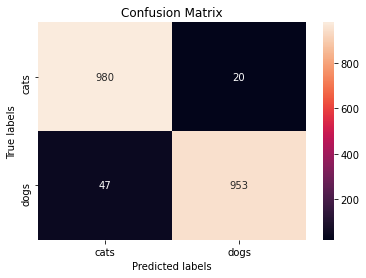

In [ ]:
summary(pred, actual)

## SVM

In [ ]:
image_size = (64,64)
def transform (img):
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, image_size)
    img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    img = img.flatten()    
    return img

training_data_x = np.array([transform(raw_training_data[i][0]) for i in range(len(raw_training_data))])
test_data_x = np.array([transform(raw_test_data[i][0]) for i in range(len(raw_test_data))])
training_data_y = np.array([raw_training_data[i][1] for i in range(len(raw_training_data))])
test_data_y = np.array([raw_test_data[i][1] for i in range(len(raw_test_data))])

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

training_time = []
accuracy = []
kernels = ["linear", "2_degree_poly", "3_degree_poly", "rbf", "sigmoid"]
for k in kernels:
    if not "poly" in k:
        model = SVC(kernel = k)
    else:
        model = SVC(kernel = "poly", degree = 2 if "2" in k else 3)
    start_time = time.time()
    model.fit(training_data_x, training_data_y)
    training_time.append(int(time.time() - start_time))
    predicted = model.predict(test_data_x)
    accuracy.append(accuracy_score(test_data_y, predicted))

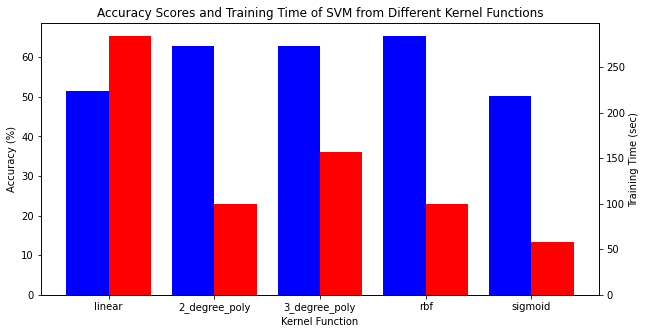

In [ ]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot()
ax2 = ax1.twinx()
x_axis = np.arange(len(kernels))
ax1.bar(x_axis - 0.2, [x*100 for x in accuracy], color='blue', width=0.4)
ax2.bar(x_axis + 0.2, training_time, color='red', width=0.4)
plt.title("Accuracy Scores and Training Time of SVM from Different Kernel Functions")
ax1.set_xlabel("Kernel Function")
ax1.set_ylabel('Accuracy (%)')
ax2.set_ylabel('Training Time (sec)')
plt.xticks(x_axis, kernels)
plt.show()

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

dim = np.linspace(2, 4096, 10).astype(int)
accuracy = []
for x in dim:
    pipe = Pipeline(steps=[('scaler', StandardScaler()),
                           ('pca', PCA(n_components = x)),
                           ('classifier', SVC(kernel = 'rbf'))])
    pipe.fit(training_data_x, training_data_y)
    predicted = pipe.predict(test_data_x)
    accuracy.append(accuracy_score(test_data_y, predicted))

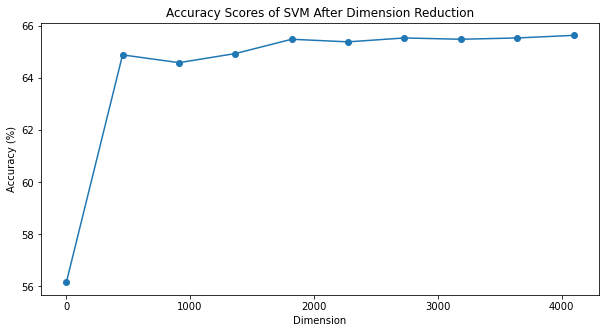

In [ ]:
fig = plt.figure(figsize=(10,5))
plt.scatter(dim.tolist(), [x*100 for x in accuracy])
plt.plot(dim.tolist(), [x*100 for x in accuracy])
plt.title("Accuracy Scores of SVM After Dimension Reduction")
plt.xlabel("Dimension")
plt.ylabel("Accuracy (%)")
plt.show()

In [ ]:
cur_dim = dim[1]
dim = np.linspace(2, cur_dim, 10).astype(int)
accuracy = []
for x in dim:
    pipe = Pipeline(steps=[('scaler', StandardScaler()),
                           ('pca', PCA(n_components = x)),
                           ('classifier', SVC(kernel = 'rbf'))])
    pipe.fit(training_data_x, training_data_y)
    predicted = pipe.predict(test_data_x)
    accuracy.append(accuracy_score(test_data_y, predicted))

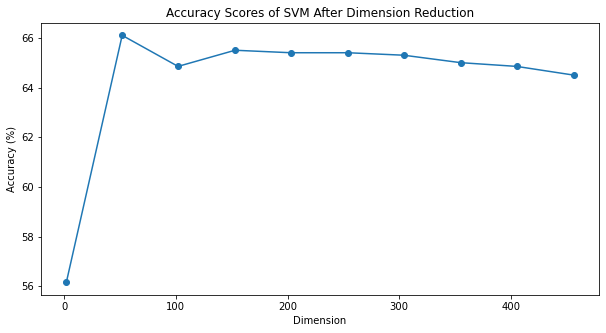

In [ ]:
fig = plt.figure(figsize=(10,5))
plt.scatter(dim.tolist(), [x*100 for x in accuracy])
plt.plot(dim.tolist(), [x*100 for x in accuracy])
plt.title("Accuracy Scores of SVM After Dimension Reduction")
plt.xlabel("Dimension")
plt.ylabel("Accuracy (%)")
plt.show()

In [ ]:
cur_dim = dim[1]
dim = np.linspace(2, cur_dim, 10).astype(int)
accuracy = []
for x in dim:
    pipe = Pipeline(steps=[('scaler', StandardScaler()),
                           ('pca', PCA(n_components = x)),
                           ('classifier', SVC(kernel = 'rbf'))])
    pipe.fit(training_data_x, training_data_y)
    predicted = pipe.predict(test_data_x)
    accuracy.append(accuracy_score(test_data_y, predicted))

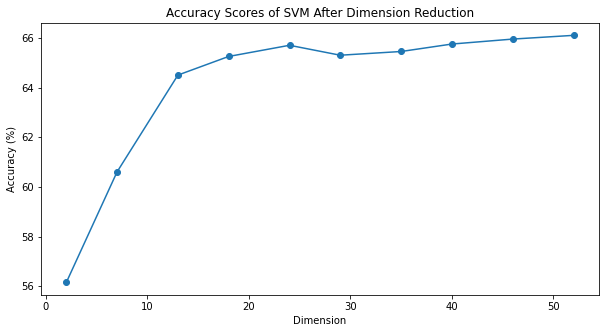

In [ ]:
fig = plt.figure(figsize=(10,5))
plt.scatter(dim.tolist(), [x*100 for x in accuracy])
plt.plot(dim.tolist(), [x*100 for x in accuracy])
plt.title("Accuracy Scores of SVM After Dimension Reduction")
plt.xlabel("Dimension")
plt.ylabel("Accuracy (%)")
plt.show()

In [ ]:
print(dim[2])

13


In [ ]:
gamma = [1.0e-1, 1.0e-2, 1.0e-3, 1.0e-4, 1.0e-5, 1.0e-6, 1.0e-7, 1.0e-8]
accuracy = []
for x in gamma:
    pipe = Pipeline(steps=[('scaler', StandardScaler()),
                           ('pca', PCA(n_components = dim[2])),
                           ('classifier', SVC(kernel = 'rbf', gamma = x))])
    pipe.fit(training_data_x, training_data_y)
    predicted = pipe.predict(test_data_x)
    accuracy.append(accuracy_score(test_data_y, predicted))

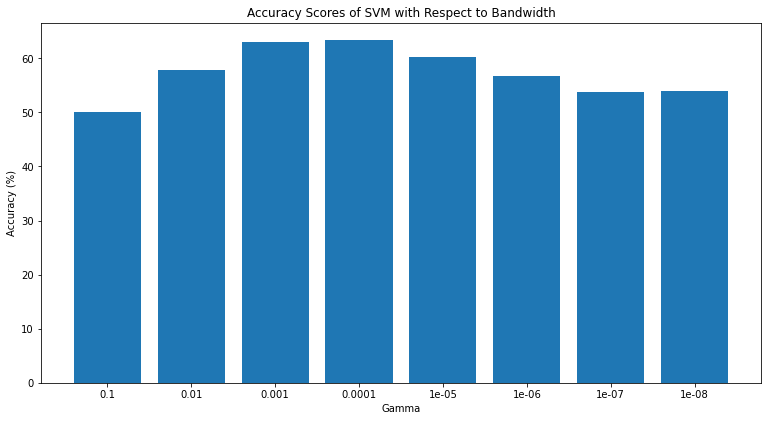

In [ ]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])
ax.bar([str(x) for x in gamma], [x*100 for x in accuracy])
plt.title("Accuracy Scores of SVM with Respect to Bandwidth")
plt.xlabel("Gamma")
plt.ylabel("Accuracy (%)")
plt.show()

In [ ]:
gamma = np.linspace(gamma[2], gamma[4], 10).astype(float)
accuracy = []
for x in gamma:
    pipe = Pipeline(steps=[('scaler', StandardScaler()),
                           ('pca', PCA(n_components = dim[2])),
                           ('classifier', SVC(kernel = 'rbf', gamma = x))])
    pipe.fit(training_data_x, training_data_y)
    predicted = pipe.predict(test_data_x)
    accuracy.append(accuracy_score(test_data_y, predicted))

In [ ]:
print(accuracy)

[0.63, 0.6315, 0.6335, 0.6295, 0.6355, 0.6375, 0.645, 0.645, 0.637, 0.603]


In [ ]:
gamma = np.linspace(gamma[5], gamma[8], 10).astype(float)
accuracy = []
for x in gamma:
    pipe = Pipeline(steps=[('scaler', StandardScaler()),
                           ('pca', PCA(n_components = dim[2])),
                           ('classifier', SVC(kernel = 'rbf', gamma = x))])
    pipe.fit(training_data_x, training_data_y)
    predicted = pipe.predict(test_data_x)
    accuracy.append(accuracy_score(test_data_y, predicted))

In [ ]:
print(accuracy)

[0.638, 0.6425, 0.6455, 0.645, 0.646, 0.6455, 0.645, 0.6425, 0.6365, 0.637]


In [ ]:
pipe = Pipeline(steps=[('scaler', StandardScaler()),
                       ('pca', PCA(n_components = dim[2])),
                       ('classifier', SVC(kernel = 'rbf', gamma = gamma[4]))])
start_time = time.time()
pipe.fit(training_data_x, training_data_y)
training_time = time.time() - start_time
predicted = pipe.predict(test_data_x)
print("Training Time {:.4f} sec".format(training_time))

Training Time 3.7859 sec


              precision    recall  f1-score   support

        cats       0.65      0.62      0.64      1000
        dogs       0.64      0.67      0.65      1000

    accuracy                           0.65      2000
   macro avg       0.65      0.65      0.65      2000
weighted avg       0.65      0.65      0.65      2000



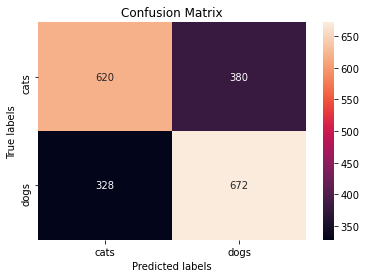

In [ ]:
summary(predicted, test_data_y)